In [ ]:
#| default_exp basics

In [ ]:
#| export

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate
from skimage import io, transform
import mcubes
import h5py
import os
from typing import Iterable
import pymeshlab
import tifffile
import json

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/lib/python3.9/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



## Basic example of tissue cartography workflow

In this notebook, we go through a basic example of tissue cartography - extracting the mildly curved surface of an epithelium from a confocal $z$-stack (data from (Lye et al. 2024)[https://doi.org/10.1371/journal.pbio.3002611]
We introduce the different functions of our python module one by one.

### Important conventions

1. Image axis 0 is always the channel. All other axes are not permuted
2. Mesh coordinates are always in microns. Mesh coordinates are always positive, since they are derived from pixel coordinates, 
3. In saved `.tif` files, `-1` represents missing data/NaN.
4. The UV map target domain is always the unit square, $u\in[0,1], \; v\in[0,1]$

### To do 

Blender stuff

1. Show multiple normally evolved meshes with onion layers and some transparency as a quasi-volume?
2. Add button to blender for pullback generation.
3. Fix voxel visualization in blender MicroscopyNodes

## Load and subsample data for segmentation

**Data description** myosin + membrane ventral view of Drosophila embryo during germband extension, from Lye et al. 2024.

We begin by creating a directory for our project where we'll save all related files and the jupyter notebook used to generate them (this one!).

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [ ]:
#| export

def adjust_axis_order(image, channel_axis=None):
    """
    Adjust axis order of image (numpy array) so that the channel axis is axis 0. 
    
    If channel axis is not specified, it is infered as the axis with the smallest number of entries.
    If the image contains a single channel, this function adds a singleton dimension.
    Axis order is otherwise left unchanged. Image must have 3 axes (single channel volumetric)
    or four axes (multichannel volumetric). 
    
    Parameters
    ----------
    image: np.ndarray with 3 or 4 axes
        Input image.
    channel_axis: int or None, optional
        Channel axis
    
    Returns
    -------
    transposed image: np.ndarray with 4 axes
        Input image, channel now axis 0.
    """
    assert 2 < len(image.shape) <5 , "image must have 3 or 4 axes"
    if len(image.shape) == 3:
        return image[np.newaxis]
    if channel_axis is None:
        channel_axis = np.argmin(image.shape)
    return np.moveaxis(image, channel_axis, 0)

In [ ]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3)}

In [ ]:
metadata_dict['subsampling_factors']

(1, 0.3333333333333333, 0.3333333333333333)

In [ ]:
image = adjust_axis_order(io.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [ ]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [ ]:
#| export

def save_h5(filename, image, h5_dataset_name="image"):
    """Save image (numpy array) as .h5 file (e.g. as input for ilastik)."""
    with h5py.File(filename, "w") as f:
        f.create_dataset('image', data=image)
    return None

def load_h5(filename):
    """Load .h5 file (e.g. ilastik output) into numpy array. Loads alphabetically first entry in .h5."""
    with h5py.File(filename, "r") as f:
        arr = f[sorted(f.keys())[0]][()] 
    return arr

In [ ]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

save_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [ ]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = load_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


<matplotlib.image.AxesImage>

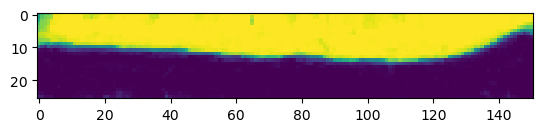

In [ ]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. First, we introduce a couple of functions for mesh io and mesh handling. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [ ]:
#| export

def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    
    Returns
    -------
    iterator
        flattened list.
    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el
            
def str_to_int_or_nan(x):
    """Convert string to int or np.nan if string is empty"""
    if x == '':
        return np.nan
    return int(x)

def int_or_nan_to_str(x):
    """Convert int/nan to string. np.nan is converted to empty string"""
    if np.isnan(x):
        return ''
    return str(x)

def pad_list(lst, length=3, fill_value=np.nan):
    """Pad end of list with fill_value if shorter than desired length."""
    return lst + max([0, (length-len(lst))]) * [fill_value,]

def read_obj(filename):
    """
    Return vertices, texture vertices, normals, and faces from an obj file.
    
    Faces are lists of 3-tuples vertex/texture vertex/normal. If a certain vertex has no texture or normal 
    associated to it, the entry is np.nan, else it is an index into the vertex, texture, and normal arrays
    (note: indices of returned faces start at 0!). See https://en.wikipedia.org/wiki/Wavefront_.obj_file.

    Parameters
    ----------
    filename : str
        filename
    Returns
    -------
    mesh: dict with entries "vertices", "texture_vertices", "normals", and "faces"
        vertices, texture_vertices, and normals are np.arrays, faces is a list of lists.
    """

    
    with open(filename, 'r') as f:
        lines = f.readlines()
    vs = np.array([ln.split()[1:] for ln in lines if ln.startswith("v ")]).astype(float)
    vts = np.array([ln.split()[1:] for ln in lines if ln.startswith("vt ")]).astype(float)
    ns = np.array([ln.split()[1:] for ln in lines if ln.startswith("vn ")]).astype(float)
    fs = [ln.split()[1:] for ln in lines if ln.startswith("f ")]
    fs = [[pad_list([str_to_int_or_nan(y)-1 for y in x.split("/")], length=3, fill_value=np.nan)
           for x in f] for f in fs]
    mesh = {"vertices": vs, "texture_vertices": vts, "normals": ns, "faces": fs}
    return mesh

def write_obj(filename, faces, vertices, texture_vertices=None, normals=None, indices_start_at_one=False):
    """
    Write mesh to .obj format
    
    Can write texture coordinates and normals if included. 
    
    Parameters
    ----------
    filename : str
        filename to save to
    vertices : np.array of shape (..., 3)
        vertices
    faces : list 
        Faces. A face can be either a list of vertex indices, or a list of vertex/texture/normal index tuples.
        Indices can be np.nan or None to represent missing data.
    texture_vertices: np.array of shape (..., 2), optional
        Texture vertices
    normals: np.array of shape (..., 3), optional
         Normals
    indices_start_at_one : bool, default True
        Whether face indices start at one or at 0.
    
    Returns
    -------
    None
    
    """
    faces_include_texture = all([isinstance(v, Iterable) for v in flatten(faces, max_depth=1)])
    if not faces_include_texture:
        with open(filename, 'w') as f:
            for v in vertices:
                f.write("v {} {} {}\n".format(*v))
            for fc in faces:
                if not indices_start_at_one:
                    fc = [v+1 for v in fc]
                f.write("f {} {} {}\n".format(*fc))
    if faces_include_texture:
        assert all([len(v) ==3 for v in flatten(faces, max_depth=1)]), "each vertex should contain 3 indices"
        texture_vertices = [] if texture_vertices is None else texture_vertices
        normals = [] if normals is None else normals
        with open(filename, 'w') as f:
            for v in vertices:
                f.write("v {} {} {}\n".format(*v))
            for vt in texture_vertices:
                f.write("vt {} {}\n".format(*vt))
            for n in normals:
                f.write("vn {} {} {}\n".format(*n))
            for fc in faces:
                if not indices_start_at_one:
                    fc = [[ix+1 for ix in v] for v in fc]
                fc = [[int_or_nan_to_str(ix) for ix in v] for v in fc]
                f.write("f {} {} {}\n".format(*["{}/{}/{}".format(*v) for v in fc]))
    return None

def match_vertex_info(faces, vertices, texture_vertices, normals):
    """
    Match up 3d vertex coordinates / texture coordinates / normals based on face connectivity.
    
    Parameters
    ----------
    faces : list
        List of faces. Each face is a list of vertex/texture vertex/normal array index triples. Indices start at 0!
    vertices : np.array of shape (..., 3)
        Vertices
    texture_vertices: np.array of shape (..., 2)
        Texture vertices
    normals: np.array of shape (..., 3)
         Normals
    
    Returns
    -------
    dict with entries:
        vertices : np.array of shape (n_matched, 3)
            Matched vertices
        texture_vertices: np.array of shape (n_matched, 2)
            Matched texture vertices
        normals: np.array of shape (n_matched, 3)
            Matched normals

    """
    unique_v_vt_n_pairs = set([tuple(x) for x in flatten([fc for fc in faces
                                                      if not np.isnan(list(flatten(fc))).any()], max_depth=1)])

    matched_vertices = np.stack([vertices[ix[0]] for ix in unique_v_vt_n_pairs])
    matched_texture_vertices = np.stack([texture_vertices[ix[1]] for ix in unique_v_vt_n_pairs])
    matched_normals = np.stack([normals[ix[2]] for ix in unique_v_vt_n_pairs])
    return {"vertices": matched_vertices,
            "texture_vertices": matched_texture_vertices,
            "normals": matched_normals}

In [ ]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian") # converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [ ]:
write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj", faces, vertices_in_microns,
          indices_start_at_one=False)

### Optional - improve mesh quality using MeshLab

We can remesh the output of the marching cubes algorithm to obtain an improved mesh, i.e. with more uniform triangle shapes. In this example, we first remesh to make the mesh more uniform.
You can also try this out in the MeshLab GUI and export your workflow as a python script. Be careful not to move the mesh or it will mess up the correspondence with the pixel coordinates!

See [List of MeshLab filers](https://pymeshlab.readthedocs.io/en/latest/filter_list.html)

In [ ]:
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
ms.meshing_isotropic_explicit_remeshing()
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

To check all went well, let's overlay the mesh coordinates over a cross section of the image. To do so, we first select the vertices whose positions correspond to the image slice, and then correctly rescale coordinates from microns to pixel coordinates.

<matplotlib.image.AxesImage>

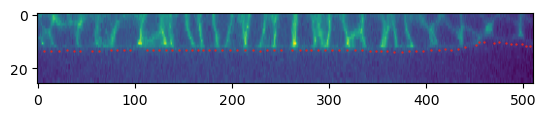

In [ ]:
image = adjust_axis_order(io.imread(f"{metadata_dict['filename']}.tif"))
vertices = read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")['vertices']

slize_index = 200
slice_coordinate = slize_index*metadata_dict["resolution_in_microns"][1]
slize_vertices = vertices[np.abs(vertices[:,1]-slice_coordinate) < 1]
plt.scatter(slize_vertices[:,2]/metadata_dict["resolution_in_microns"][2],
            slize_vertices[:,0]/metadata_dict["resolution_in_microns"][0], s=0.5, c="tab:red")

plt.imshow(image[1,:,slize_index,:], aspect=(metadata_dict["resolution_in_microns"][0]
                                     /metadata_dict["resolution_in_microns"][1]))

## UV-mapping in blender

We now switch to blender and create a new empty project, which we will call `f"{metadata_dict['filename']}.blend"`. We import the mesh just generated (File->Import).

<div>
    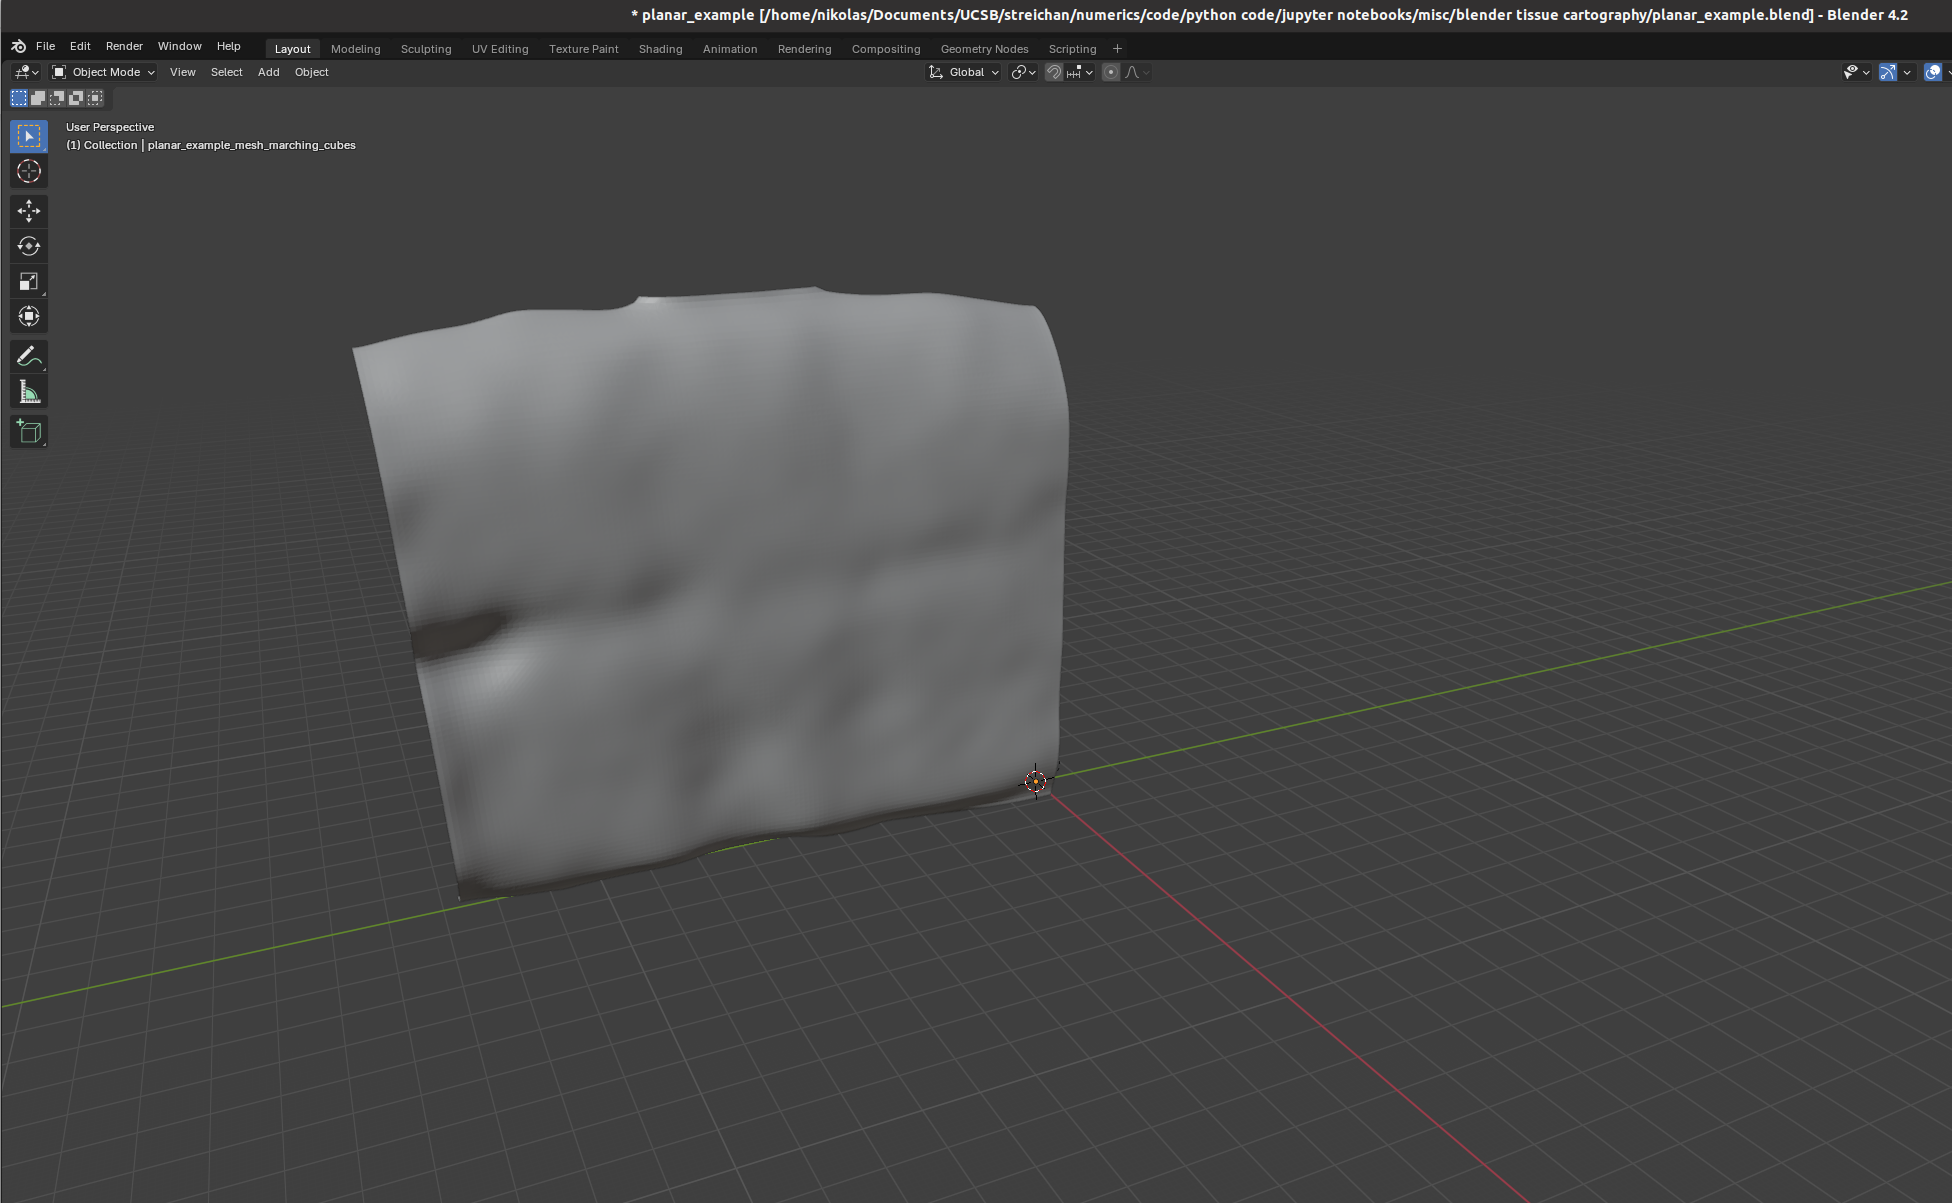
</div>

I recommend using the "object" tab (orange square on right toolbar) to lock mesh position and rotation so we don't accidentally move it.

To 3d-render the underlying data, we can use the [MicroscopyNodes](https://github.com/oanegros/MicroscopyNodes) plugin. Go to the right hand panel:
<div>
    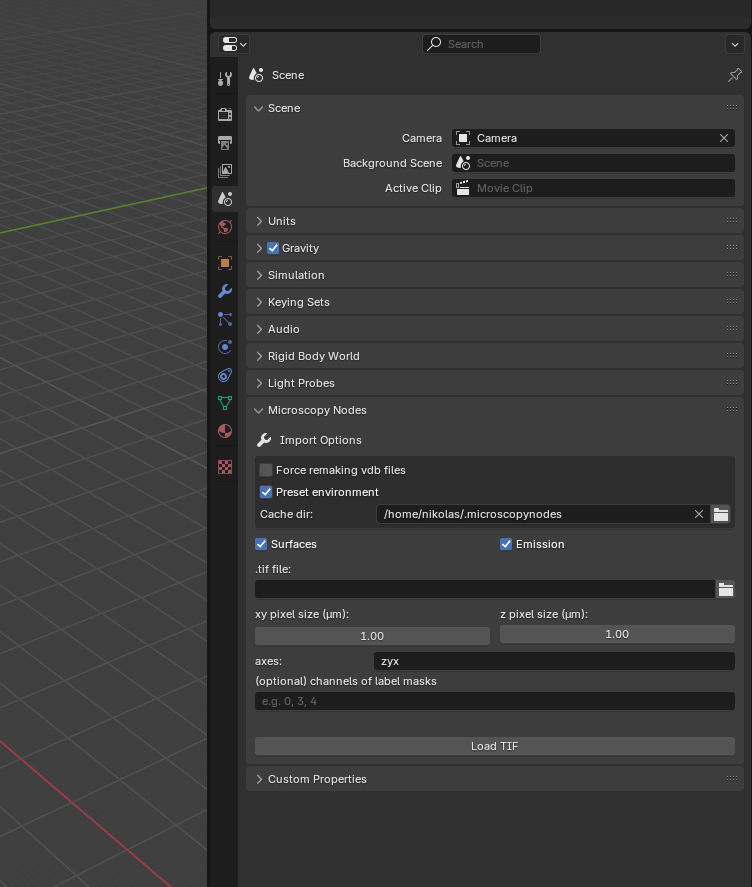
</div>

So far this does not yet work as intended - MicroscopyNodes rescales coordinates in such a way that they do mot overlap with the mesh. Fixing this should be a simple matter of translating and rescaling the objects created by MicroscopyNodes. **To do**: need to figure out what scaling factor the plugin uses. This is what the MicroscopyNodes developer says:

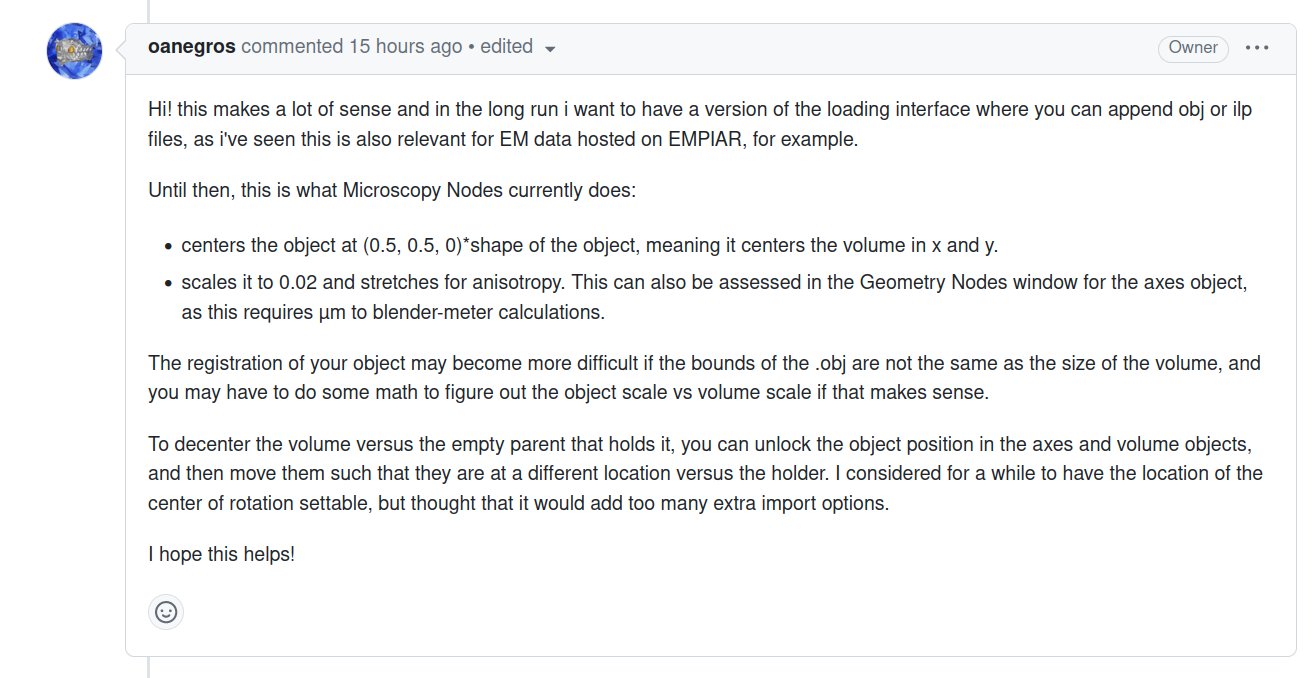

Let's try to move forward and get a UV map of the mesh. To do so, we go to the "UV Editing" tab on the top toolbar, press "3" then "A" to select all faces ("1" selects vertices, "2" edges, and "3" faces). Click "UV->unwrap" on the top panel.
<div>
    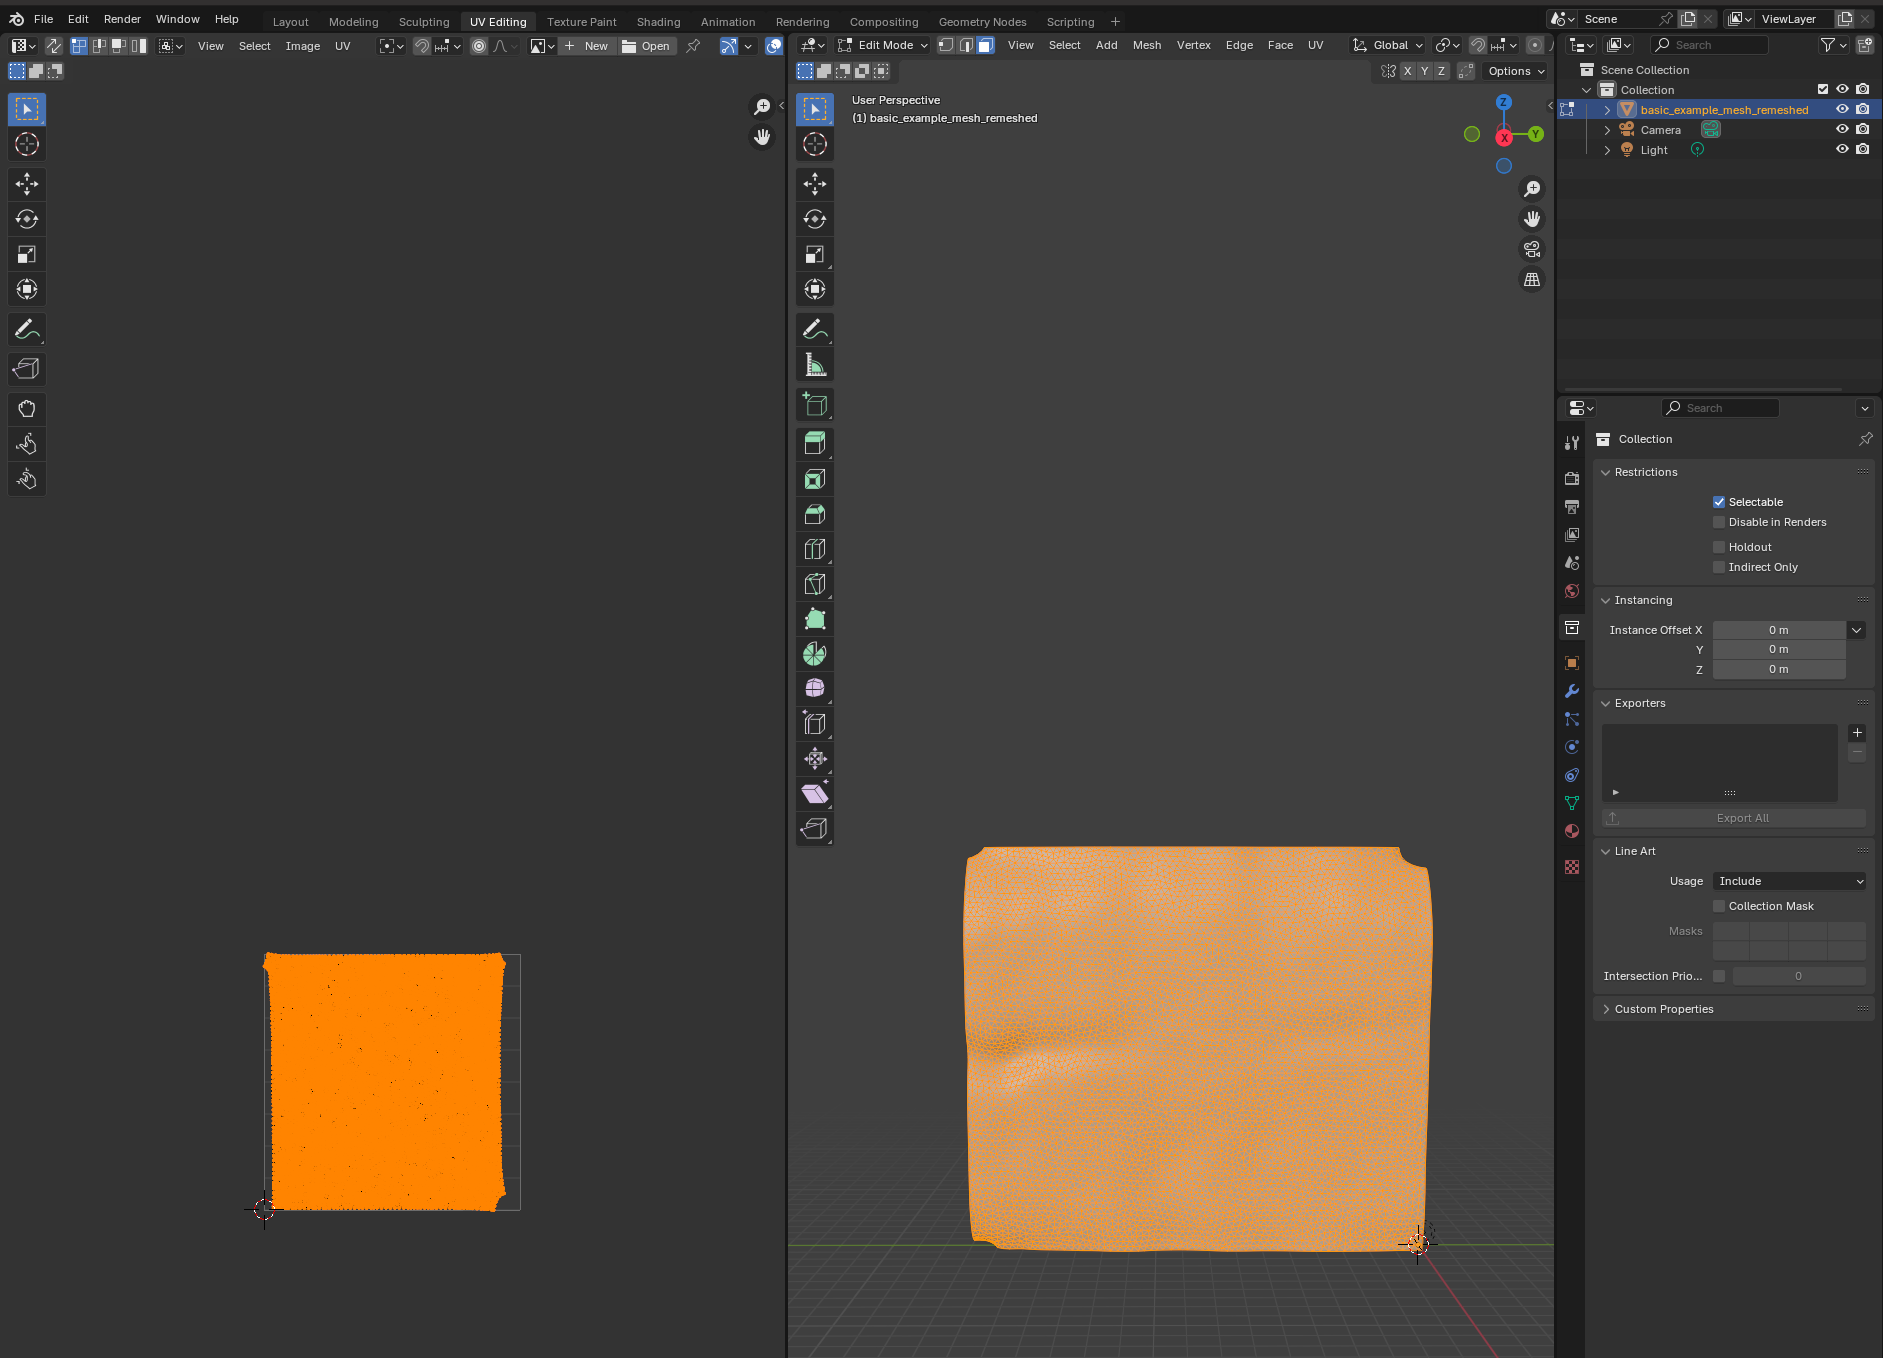
</div>

For more complicated meshes (e.g. a sphere), we will need to use extra steps, e.g. define seams.

We then click on export and save as `.obj` with UV and normals. The new mesh file `f"{metadata_dict['filename']}_mesh_uv.obj"` now contains vertex normals and UV coordinates as `vn` and `vt` lines. Note - there can be more `vt`'s than `v`'s.

### Interpolation onto UV grid

We now read in the new `.obj` file in order to interpolate the image data onto the 3d mesh. We first introduce the functions necessary to do so, which are based on the `scipy.interpolation` module. Interpolation proceeds in two steps:
1. Interpolate the 3d coordinates from the mesh UV vertex positions onto the whole UV grid
2. Evaluate the image signal at the UV gridded 3d coordinates using a second interpolation step.
This ensures that the resolution of the cartographic projection is not limited by the resolution of the mesh.

The UV grid always covers the unit cube $[0,1]^2$.

We first show how the interpolation works in a step-by-step manner, and the give a function that packages the whole process.

In [ ]:
#| export

def interpolate_3d_to_uv(matched_texture_vertices, matched_vertices_or_normals, uv_grid_steps=256):
    """
    Interpolate 3d mesh coordinates or mesh normals onto UV square.
    
    Assumes the map $x,y,z \mapsto u,v$ to be invertible. This is not guaranteed - you can create overlapping UV 
    coordinates in blender. 
    
    Parameters
    ----------
    matched_vertices_or_normals : np.array of shape (n_matched, 3)
        Vertex 3d coordinates or normals, matched to UV coordinates
    matched_texture_vertices : np.array of shape (n_matched, 2)
        Matched texture vertices. Will be mapped back to [0, 1]^2!
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.

    Returns
    -------
    interpolated_3d : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions or normals across [0,1]^2 UV grid, with uniform step size. UV positions that don't
        correspond to any value are set to np.nan.
        
    """
    matched_texture_vertices %= 1
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    interpolated_3d = np.stack([interpolate.griddata(matched_texture_vertices, x, (U, V))
                                for x in matched_vertices_or_normals.T], axis=-1)
    return interpolated_3d

In [ ]:
#| export

def interpolate_volumetric_data_to_uv(image, interpolated_3d_positions, resolution):
    """ 
    Interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_3d_to_uv.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, uv_grid_steps, uv_grid_steps)
        3d volumetric data interpolated onto UV grid.
    
    """
    x, y, z = [np.arange(ni) for ni in image.shape[1:]]
    interpolated_data = np.stack([interpolate.interpn((x, y, z), channel, interpolated_3d_positions/resolution,
                                  method="linear", bounds_error=False) for channel in image])
    
    return interpolated_data

In [ ]:
#| export

def interpolate_volumetric_data_to_uv_multilayer(image, interpolated_3d_positions, interpolated_normals,
                                                 normal_offsets, resolution):
    """ 
    Multilayer-interpolate volumetric image data onto UV coordinate grid.
    
    Uses 3d positions corresponding to each UV grid point as computed by interpolate_3d_to_uv.
    3d coordinates (in microns) are converted into image coordinates via the scaling factor.
    
    Generates multiple "layers" by shifting surface along its normals.
    
    Parameters
    ----------
    image : 4d np.array
        Image, axis 0  is assumed to be the channel axis
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan.
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d normals across [0,1]^2 UV grid, with uniform step size. UV positions that don't correspond to 
        any value are set to np.nan. Normal vectors will be automatically normalized.
    normal_offsets : np.array of shape (n_layers,)
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    resolution : np.array of shape (3,)
        Resolution in pixels/microns for each of the three spatial axes.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multulayer-interpolated onto UV grid.
    
    """
    interpolated_normals = (interpolated_normals.T / np.linalg.norm(interpolated_normals, axis=-1).T).T
    interpolated_data = np.stack([interpolate_volumetric_data_to_uv(image,
                                  interpolated_3d_positions+o*interpolated_normals, resolution)
                                  for o in normal_offsets], axis=1)
    return interpolated_data

In [ ]:
# let's read in the mesh and match up the vertices, texture vertices and normal vectors using the
# mesh connectivity information
mesh = read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
matched_mesh_data =  match_vertex_info(**mesh)

# let's also load the image
image = adjust_axis_order(io.imread(f"{metadata_dict['filename']}.tif"))

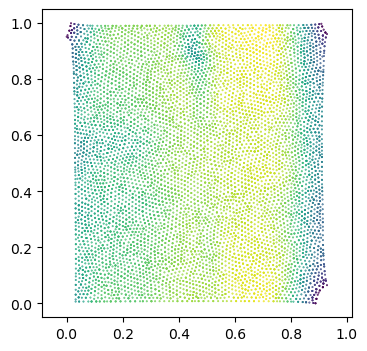

In [ ]:
# let's make a scatter plot of the mesh texture coordinates, and color it by 3d coordinate x

fig = plt.figure(figsize=(4,4),)
plt.scatter(*matched_mesh_data["texture_vertices"].T, s=0.2, c=matched_mesh_data["vertices"][:,0])
plt.axis("equal");

In [ ]:
# first interpolation step 

uv_grid_steps = 256  # set UV grid size

# this is our UV grid
u, v = 2*[np.linspace(0,1, uv_grid_steps),]
U, V = np.meshgrid(u, v)

interpolated_3d_positions = interpolate_3d_to_uv(matched_mesh_data["texture_vertices"],
                                                 matched_mesh_data["vertices"],
                                                 uv_grid_steps=uv_grid_steps)
interpolated_normals = interpolate_3d_to_uv(matched_mesh_data["texture_vertices"],
                                            matched_mesh_data["normals"],
                                            uv_grid_steps=uv_grid_steps)

<matplotlib.colorbar.Colorbar>

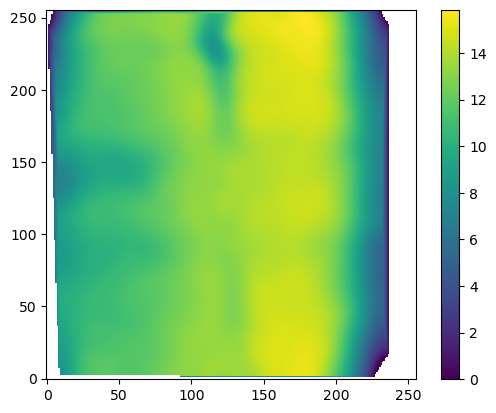

In [ ]:
# let's plot the interpolated 3d coordinates
plt.imshow(interpolated_3d_positions[:,:,0], origin='lower')
plt.colorbar()

In [ ]:
# second interpolation step. here we have to include the conversion factor from microns back to pixels

interpolated_data = interpolate_volumetric_data_to_uv(image, interpolated_3d_positions,
                                                      metadata_dict['resolution_in_microns'])

<matplotlib.colorbar.Colorbar>

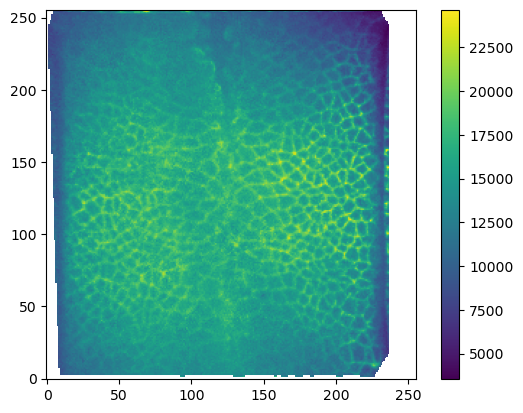

In [ ]:
plt.imshow(interpolated_data[1], origin='lower')
plt.colorbar()

In [ ]:
# now we can create a multilayer projection by  shifting the surface according to the vertex normals

normal_offsets = np.linspace(-2, 2, 5) # offset in microns

interpolated_data_multilayer = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                 interpolated_3d_positions,
                                                                 interpolated_normals,
                                                                 normal_offsets,
                                                                 metadata_dict['resolution_in_microns'])
print("Shape: axis 0 is channel, axis 1 is normal offset", interpolated_data_multilayer.shape)

Shape: axis 0 is channel, axis 1 is normal offset (2, 5, 256, 256)


<matplotlib.colorbar.Colorbar>

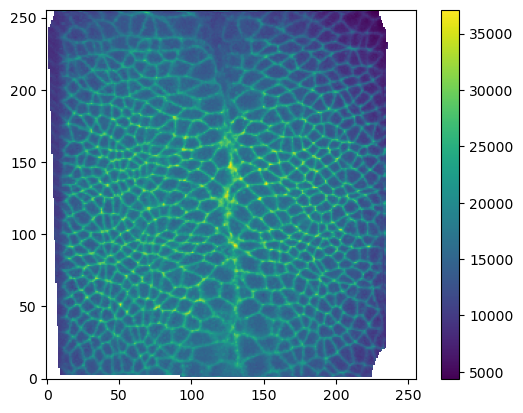

In [ ]:
plt.imshow(interpolated_data_multilayer[1, 0], origin='lower')
plt.colorbar()

#### Packaging it up

Let's package the interpolation workflow up into a single function.

In [ ]:
#| export

def create_cartographic_projections(image, mesh, resolution, normal_offsets=(0,), uv_grid_steps=256):
    """
    Create multilayer cartographic projections of image using mesh.
    
    Computes multiple layers along surface normal, with given normal offset (in microns). 0 offset
    corresponds to no shift away from the mesh. Also computes 3d positions (in microns)
    and surface normals interpolated onto the UV grid.
    
    UV positions that don't correspond to any 3d position are set to np.nan.
    
    Parameters
    ----------
    image : str or 4d np.array
        Image, either as path to file, or as array. If array, axis 0  is assumed to be the channel axis
    mesh : str or dict
        Mesh, either as path to file, or as dict with entries "vertices", "texture_vertices", "normals",
        and "faces"
    resolution : np.array of shape (3,)
        Image resolution in pixels/micron for the three spatial axes
    normal_offsets : np.array of float, optional
        Offsets along normal direction, in same units as interpolated_3d_positions (i.e. microns).
        0 corresponds to no shift.
    uv_grid_steps : int, default 256
        Size of UV grid. Determines resolution of result.
    
    Returns
    -------
    interpolated_data : np.array of shape (n_channels, n_layers, uv_grid_steps, uv_grid_steps)
        3d volumetric data multulayer-interpolated across [0,1]^2 UV grid, with uniform step size.
    interpolated_3d_positions : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        3d positions across [0,1]^2 UV grid, with uniform step size. 
    interpolated_normals : np.array of shape (uv_grid_steps, uv_grid_steps, 3)
        Normals across [0,1]^2 UV grid, with uniform step size.
    """
    if isinstance(image, str):
        image = adjust_axis_order(io.imread(image))
    if isinstance(mesh, str):
        mesh = read_obj(mesh)
    matched_mesh_data =  match_vertex_info(**mesh)
    u, v = 2*[np.linspace(0,1, uv_grid_steps),]
    U, V = np.meshgrid(u, v)
    interpolated_3d_positions = interpolate_3d_to_uv(matched_mesh_data["texture_vertices"],
                                                     matched_mesh_data["vertices"],
                                                     uv_grid_steps=uv_grid_steps)
    interpolated_normals = interpolate_3d_to_uv(matched_mesh_data["texture_vertices"],
                                                matched_mesh_data["normals"],
                                                uv_grid_steps=uv_grid_steps)
    interpolated_data = interpolate_volumetric_data_to_uv_multilayer(image,
                                                                     interpolated_3d_positions,
                                                                     interpolated_normals,
                                                                     normal_offsets,
                                                                     resolution)
    return interpolated_data, interpolated_3d_positions, interpolated_normals 

In [ ]:
normal_offsets = np.linspace(-2, 2, 5) # in microns

projected_data, projected_coordinates, projected_normals = create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"{metadata_dict['filename']}_mesh_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=256)

# let's add the normal offset we want to our metadata - it will be important for analysis!
# we'll convert it to a tuple so we can save the metadata more easily later
metadata_dict["normal_offsets"] = tuple(normal_offsets)

<matplotlib.colorbar.Colorbar>

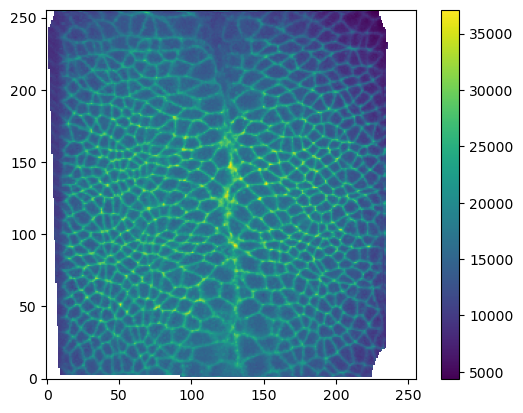

In [ ]:
plt.imshow(projected_data[1, 0], origin='lower')
plt.colorbar()

### Saving the results

We can now save the cartographic projections both as `.tif` stack for quantitative analysis, and as `.png`'s for visualization as mesh texture in blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
# save metadata
with open(f"{metadata_dict['filename']}_metadata.json", "w") as f:
    json.dump(metadata_dict, f)

In [ ]:
#| export

def save_for_imageJ(filename, image, z_axis=None, channel_axis=None):
    """
    Save image as 32bit ImageJ compatible .tif file
    
    If channel_axis is not provided, it is inferred as the shortest axis.
    If z-axis is provided for a 4d array, it will be set as the default z-axis for ImageJ.
    """
    channel_axis = np.argmin(image.shape) if channel_axis is None else channel_axis
    if len(image.shape) == 3:
        transposed_image = np.moveaxis(image, channel_axis, 0)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'CYX'}, imagej=True,)
    elif len(image.shape) == 4:
        if z_axis is not None:
            transposed_image = np.moveaxis(image, (z_axis, channel_axis), (0,1))
        else:
            transposed_image = np.moveaxis(image, channel_axis, 1)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'ZCYX'}, imagej=True,)
    return None
    
def normalize_quantiles_for_png(image, quantiles=(0.01, 0.99)):
    """
    Normalize an image by setting given quantiles to 0 and 255 and converting to 8-bit, for saving as .png
    
    Also replaces nan by 0.
    
    Parameters
    ----------
    image : np.array
        Image (should be single-channel)
    quantiles : tuple
        Image quantile to set to 0 and 255.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, datatype np.uint8
    """
    image_normalized = image - np.nanquantile(image, quantiles[0])
    image_normalized /= np.nanquantile(image_normalized, quantiles[1])
    image_normalized = np.nan_to_num(np.round(np.clip(255*image_normalized, 0, 255)), nan=0)
    return image_normalized.astype(np.uint8)
    
    
def save_stack_for_blender(image, directory, normalization=(0.01, 0.99)):
    """
    Save multichannel volumetric image as series of grayscale .png images. Can normalize data if desired.
    
    This function necessarily converts the image to 8bit. Use a suitable normalization to ensure nothing 
    is lost.
    
    Parameters
    ----------
    image : 4d np.array
        Axis 0 is assumed to be the channel axis, axis 1 is the slicing axes, i.e. images will correspond to
        slices along axis 1.
    directory : str
        Path to save data to. Will create directory if it doesn't exist
    normalization : tuple of float, or callable
        Whether to normalize the image before saving it. If None, no normalization is performed. If a
        tuple is given, it will be interpreted as quantiles to set to 0 and 255, respectively (over the
        whole channel, not each slice). If a callable is provided, it will be applied to each channel.
        
    Returns
    -------
    None
    
    """
    directory = directory.removesuffix('/')
    if not os.path.exists(directory):
        os.makedirs(directory)
    for ic, ch in enumerate(image):
        if callable(normalization):
            ch_normalized = normalization(ch)
        if isinstance(normalization, tuple):
            ch_normalized = normalize_quantiles_for_png(ch, quantiles=normalization)
        for islc, slc in enumerate(ch_normalized):
            slc = np.stack(3*[slc], axis=-1).astype(np.uint8) # necessary for saving as png
            io.imsave(f'{directory}/channel_{ic}_slice_{str(islc).zfill(3)}.png', slc, check_contrast=False)
    return None

In [ ]:
save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)
save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates)
save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

In [ ]:
# let's make a max projection of each channel and save them also

max_projected_ch_0, max_projected_ch_1 = projected_data.max(axis=1)
io.imsave(f'{texture_path}/max_channel_0.png', normalize_quantiles_for_png(max_projected_ch_0))
io.imsave(f'{texture_path}/max_channel_1.png', normalize_quantiles_for_png(max_projected_ch_1))

### Visualization in blender


You can set up textures in the "shading" tab:

<div>
    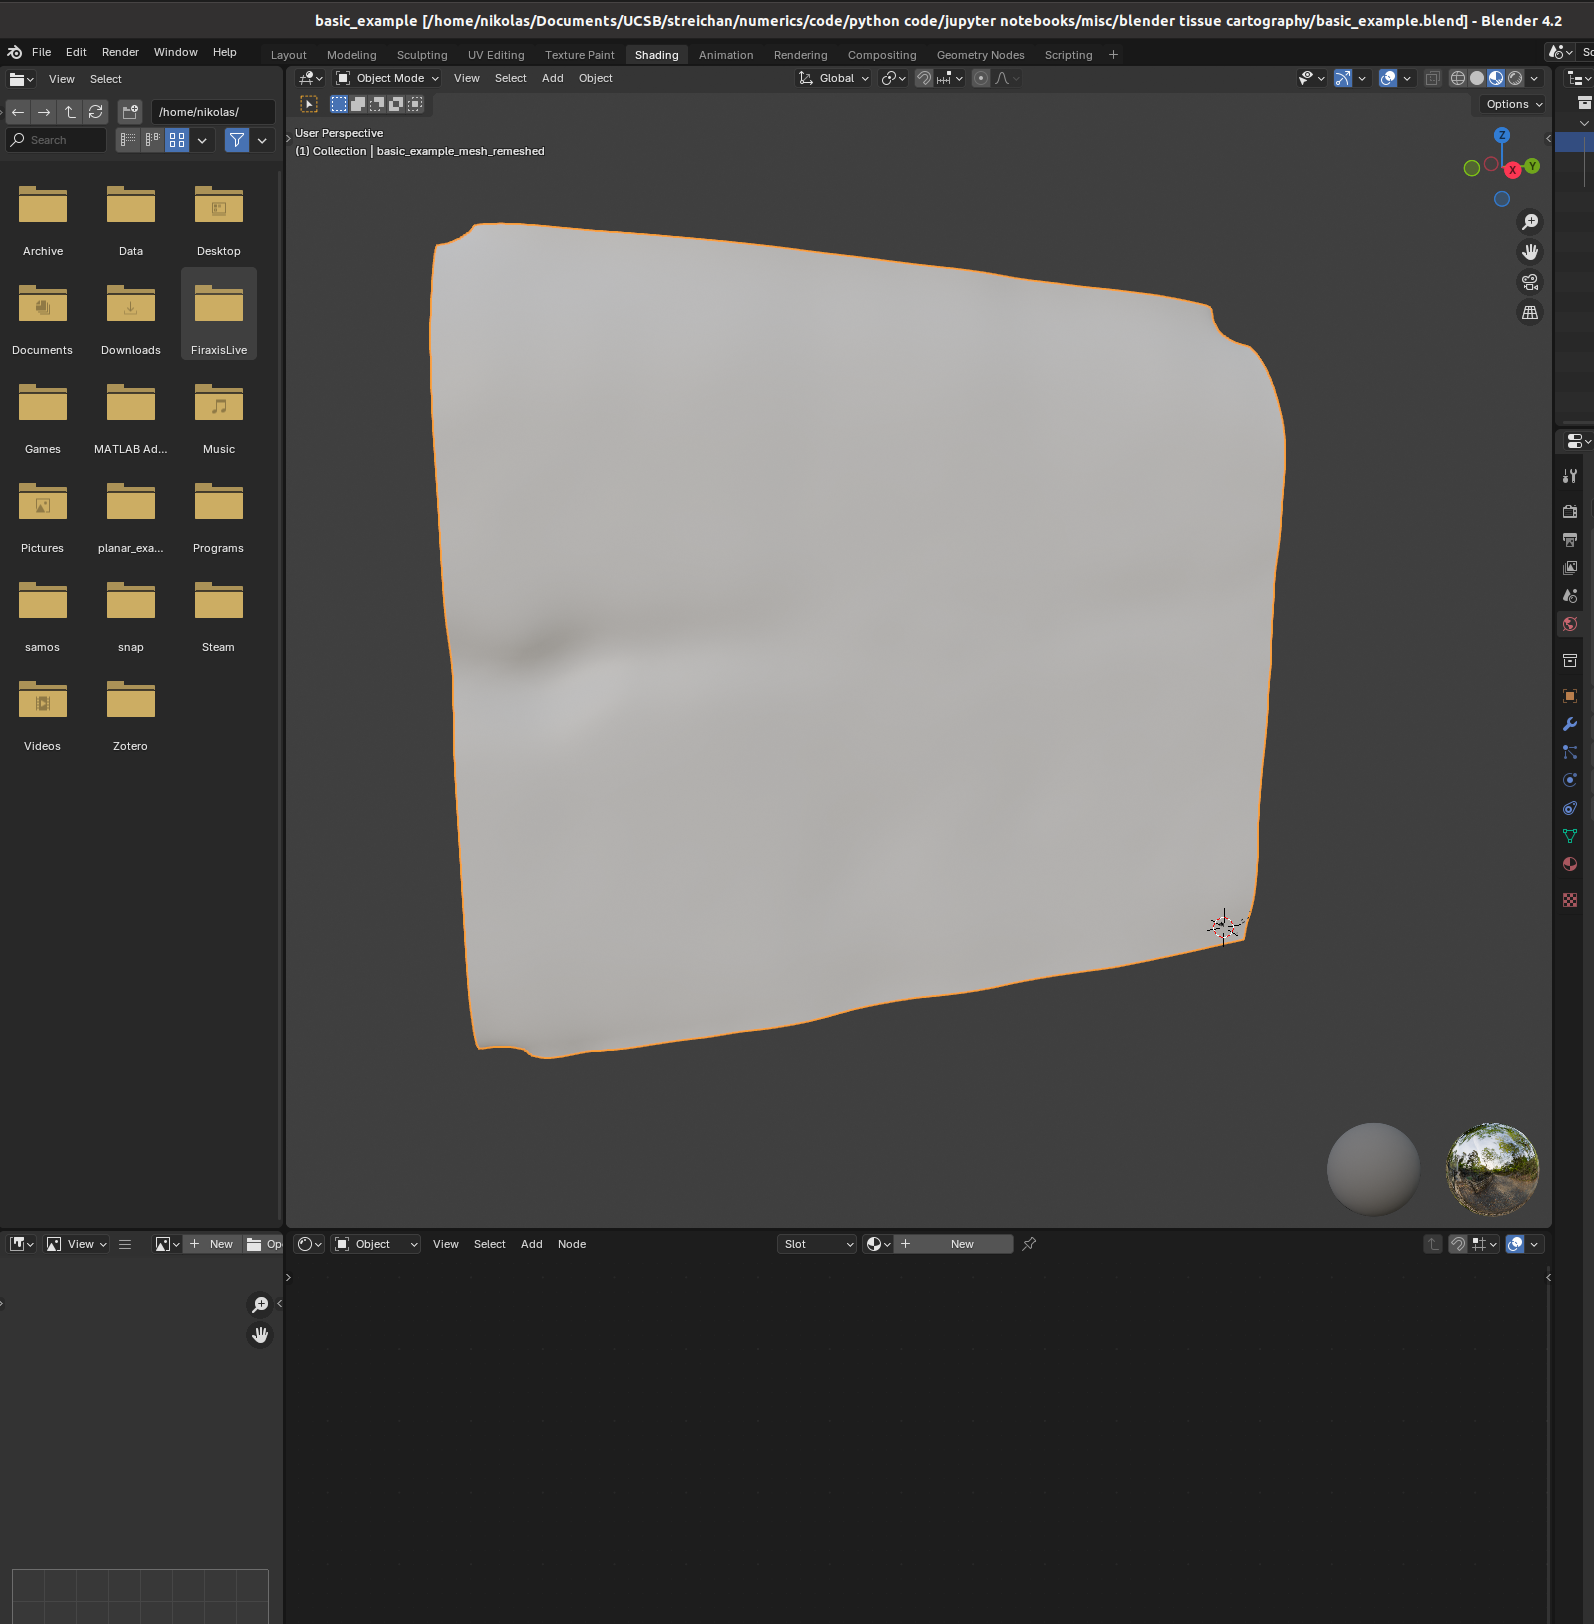
</div>


I find it helpful to remove the distracting "world" background, which you can do by either enabling "scene world" or setting "world opacity" to 0 in the viewport shading settings (arrow above "options" in top right corner)

Go to the bottom panel, add a new material (center top of bottom panel), and press "shift+A" to add a new shader element (the search bar is very helpful). Here is an example configuration mixing two channels as red and green:

<div>
    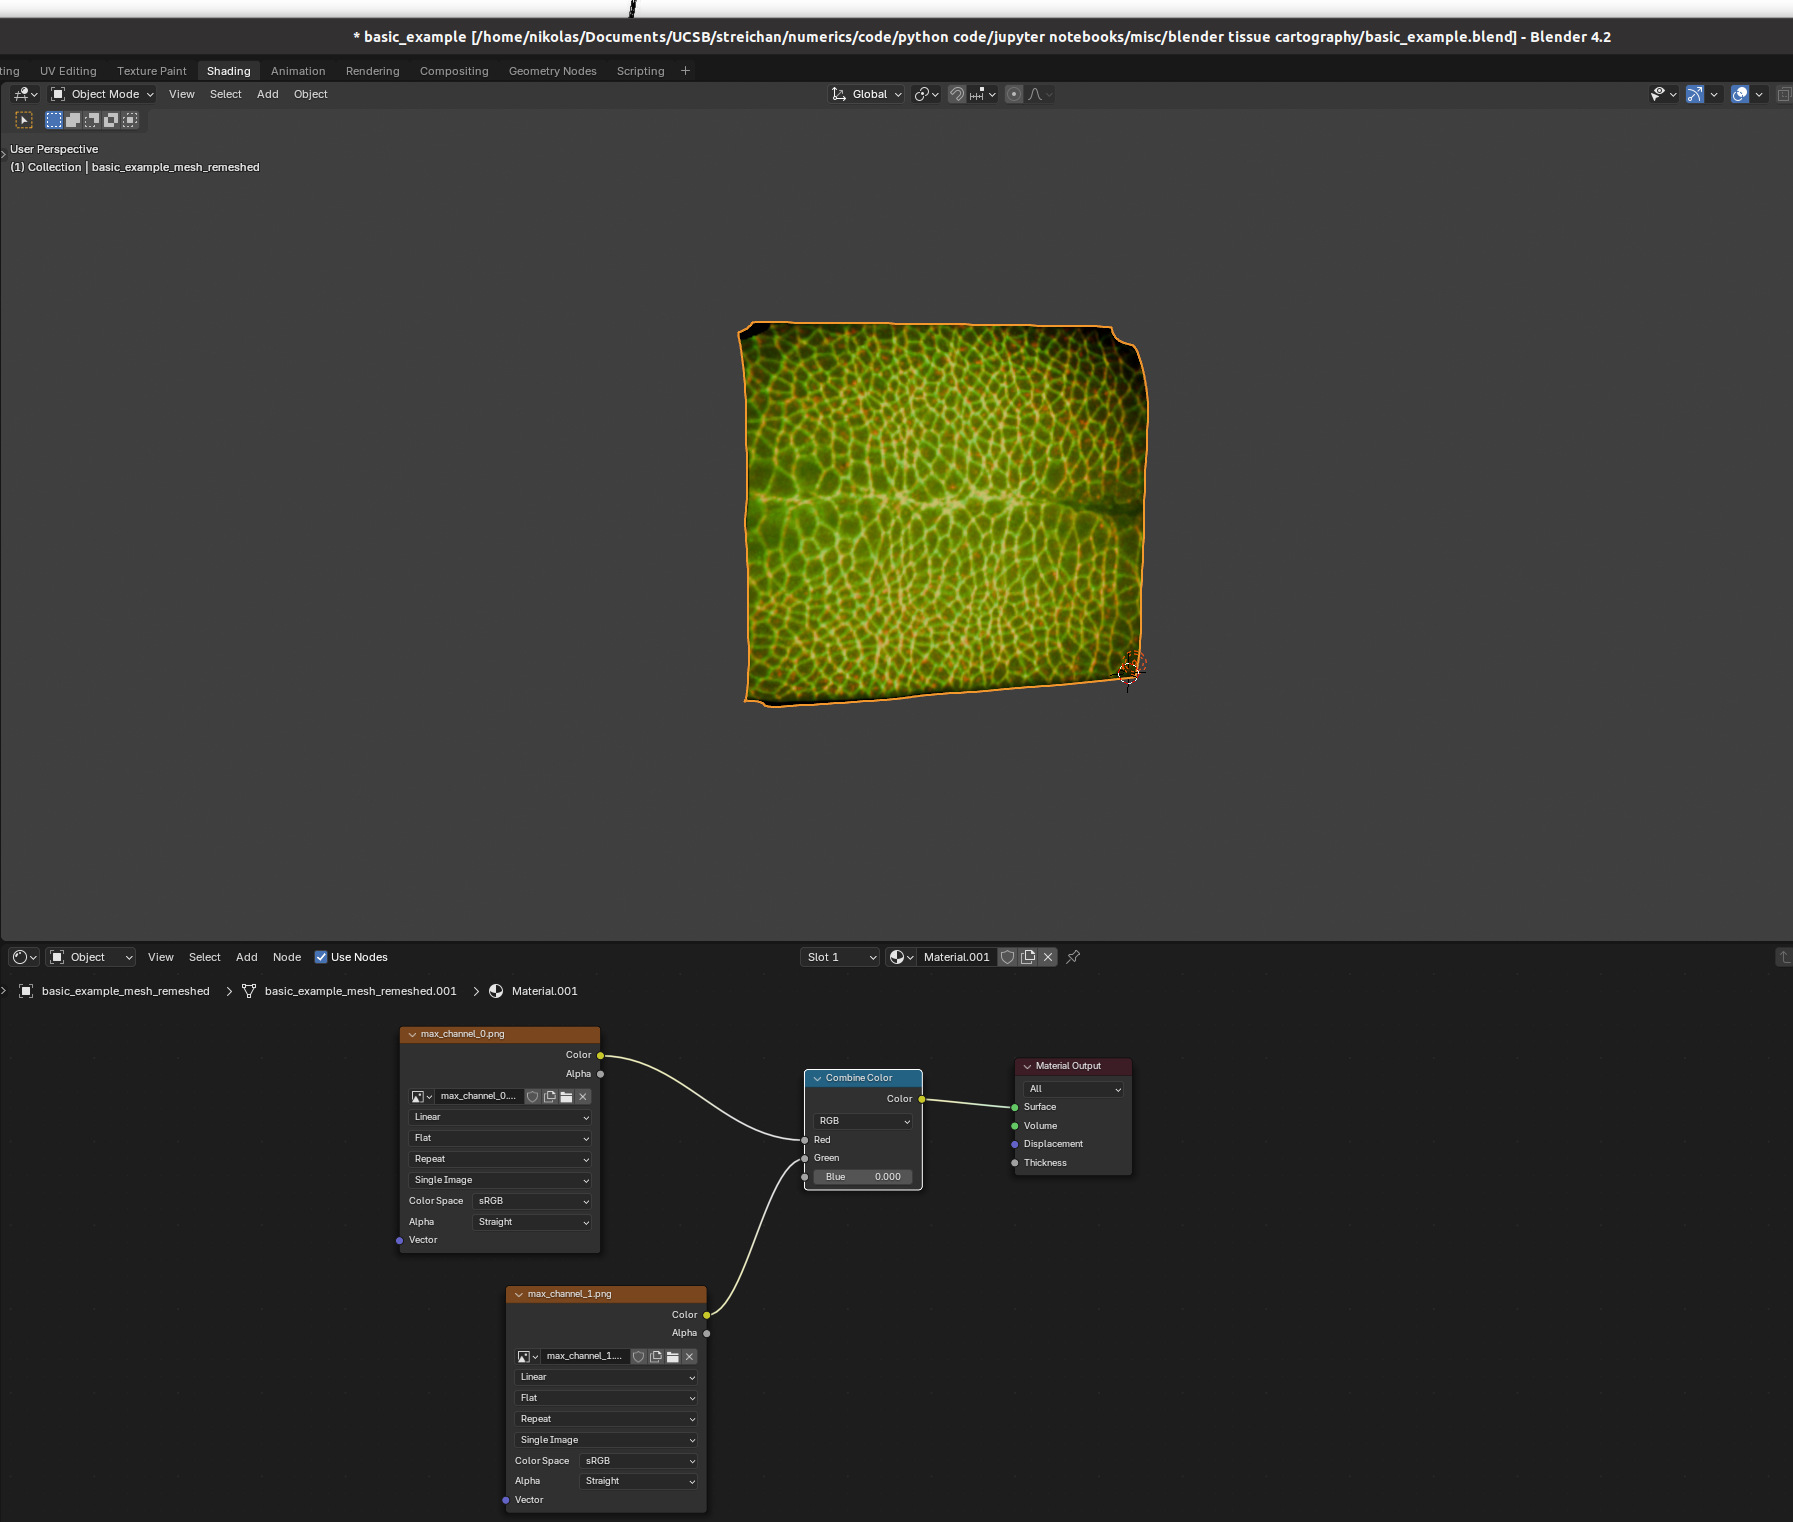
</div>

And there we go! Many further options exist to make more sophisticated renderings.

### Next steps

In the next tutorial, we will see how to UV map a more complicated shape (not topologically a disk) via seams.